In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.pca import perform_pca
from util.k_folds_cross_val import k_folds_x_val, get_cmat, get_metrics
from util.hpo import gridSearchHPO
from util.forward_select import forward_select, forward_select_and_fit

from torch.utils.data import TensorDataset, DataLoader
from util.neuralnet import NeuralNetwork
from util.trainer import training_loop, evaluate
import torch

from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import sklearn as skl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [32]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

# Load all data
train_data = pd.read_csv("../data/training_labse.csv")
test_data = pd.read_csv("../data/test_labse.csv")
validation_data = pd.read_csv("../data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

In [33]:
X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [34]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

# Principal Component Analysis (PCA)

In [35]:
TARGET_EXPLAINED_VARIANCE = 0.95

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_reduced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

180 components for training


In [36]:
X_train_used = X_train_reduced
X_val_used = X_val_reduced
X_test_used = X_test_reduced
X_train_val_used = X_train_val_reduced 
X_val_test_used = X_val_test_reduced

# Multi-Layer Perceptron

In [37]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

mlp = MLPClassifier([100, 100, 100], 'relu', solver="adam")
mlp.fit(X_train_used, Y_train)

MLPClassifier(hidden_layer_sizes=[])

In [38]:
k_folds_x_val(mlp, X_train_val_used, Y_train_val)

c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Accuracy: 0.5903333333333333


c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.5903333333333333,)

(0.562, 0.44420512828169867)


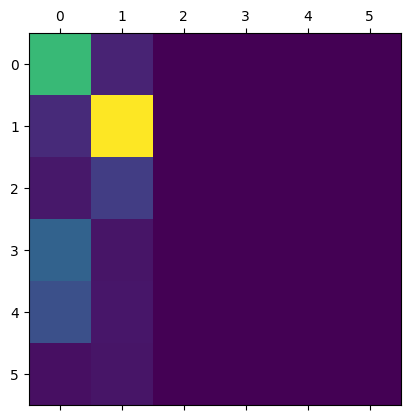

In [39]:
cmat = get_cmat(mlp, X_test_used, Y_test)
print(get_metrics(mlp, X_test_used, Y_test))
plt.matshow(cmat)
plt.show()